<a href="https://colab.research.google.com/github/asudomoeva/Cancer-detection/blob/master/ADL_Final_Project_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Deliverables 
● Video: a 10 minute YouTube video explaining your project / the key pieces of code / experiments you ran / and results. Should contain slides + code walkthrough.
● Complete code: either a Jupyter notebook that runs end-to-end on Colab, or a zip including source, a README, and a shell script to run it. Please include a saved model as well.

# Code

● Train a model using a subset of the training data from CAMELYON16.

● Include a script to run it on a testing image and generate a heatmap (note:
you do not need to create a 100,000 x 100,000 heatmap -- use a much lower
resolution).

# Results
● Design a thoughtful evaluation method, and include the results on at least
three images from the testing set.

● Include a saved, trained version of your model with your submission.

# Tips

●  “We surprisingly found that slimmed-down Inception architectures with only 3% of the parameters achieved similar performance to the full version”

● Authors found that using a pretrained model on ImageNet ultimately hurt accuracy (Why? Pathology images do not match the natural images from ImageNet) -- but -- it improved convergence speed. This is a good place to start. Try transfer learning
and/or fine-tuning.

● Start with a low zoom level (much smaller images), a simple model, and a small amount of data.

● Implement an end-to-end prototype (training data in -> heatmap on a test image out), then slowly scale up.

● Begin with transfer learning from a model trained on ImageNet, then fine-tuning, then consider training a model from scratch. Only after this is working end-to-end, consider data augmentation, using higher zooms,
etc.

## Setup

### Compute env/package setup

In [5]:
!pip show tensorflow

Name: tensorflow
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: termcolor, wheel, keras-applications, numpy, gast, tensorboard, protobuf, tensorflow-estimator, grpcio, absl-py, keras-preprocessing, astor, six
Required-by: stable-baselines, magenta, fancyimpute


In [6]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 42kB/s 
     |████████████████████████████████| 61kB 26.3MB/s 
     |████████████████████████████████| 419kB 47.5MB/s 
     |████████████████████████████████| 3.0MB 50.3MB/s 


In [8]:
!pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 2.0.0a0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: gast, keras-preprocessing, protobuf, astor, absl-py, numpy, grpcio, google-pasta, tb-nightly, wheel, tf-estimator-nightly, six, termcolor, keras-applications
Required-by: 


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (101 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, VGG19, ResNet50
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

import os
import pandas as pd
import random

from keras import models
from keras import layers
from keras import optimizers

### Defining Helper Functions

Here, we are defining all of the helper functions used throughout the notebook.

In [0]:
# a function to determine whether there is a tissue present in the sliding window
def is_tissue_in_window(window, intensity=0.8):
    im_gray = rgb2gray(window)
    x_indices = np.where(im_gray <= intensity)[0]
    return len(x_indices) > 0

# a function to read the slide
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
# a function for data augmentation
def augment_window(window):
  tf_img = tf.convert_to_tensor(window)
  flipped_img = tf.image.flip_left_right(tf_img).eval()
  results = []
  for img in [tf_img, flipped_img]:
    for i in range(4):
      result = tf.image.rot90(img, k=i)
      result = tf.image.random_contrast(result, 0.75, 1.25)
      result = tf.image.random_hue(result, 0.04)
      result = tf.image.random_saturation(result, 0.75, 1.25)
      result = tf.image.random_brightness(result, 0.25)
      results.append(result.eval())
  return results

# a function to create dataset of arrays for each window with tissue and corresponding labels
def create_dataset(level, image_names, with_augmentation=False):
    #creating lists for final data and labels
    data = []
    labels = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[level][0]
        y_max = slide.level_dimensions[level][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[level][0] == x_max
        assert tumor_mask.level_dimensions[level][1] == y_max

        # choosing downsample factor
        downsample_factor = int(slide.level_downsamples[level])

        #initiatize coordinates
        x0 = 0 #int(.05*x_max) possibility to create padding
        y0 = 0 #int(.05*y_max) possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))

        #calculate how many steps we can take with 299x299 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim)) # I don't think we need the -1 above since int() already rounds down
        print('x steps: ' + str(x_steps) + ' y steps: '+ str(y_steps))
        
        window_labels = []
        window_data = []
        negative_data = []
        for i in range(x_steps):
            for j in range(y_steps): 
                #generating a window from the original slide
                window = read_slide(slide, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))
                #conducting sanity check
                assert window.shape == (x_dim, y_dim, 3)

                #if window contains tissue, append to train
                if is_tissue_in_window(window) is True:
                    #continue # No tissue in this window, don't add to train or test
                    window_data.append(window)
                    
                    if with_augmentation is True:
                      window_data.extend(augment_window(window))
                    
                    # read the tumor mask view that corresponds to the window
                    window_mask = read_slide(tumor_mask, 
                                     x=int(x0)*downsample_factor, 
                                     y=int(y0)*downsample_factor, 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))[:,:,0]

                    #if window contains cancer, append 1 to labels; else 0
                    if np.count_nonzero(window_mask.flatten()) > 0:
                        #labels.append(1)
                        window_label = 1
                    else:
                        #labels.append(0)
                        window_label = 0
                    
                    if with_augmentation is True:
                      window_labels.extend([window_label] * 9)
                    else:
                      window_labels.append(window_label)

                
                #move the sliding window on y axis
                y0 = y0 + y_dim

            #move the sliding window on x axis
            x0 = x0 + x_dim
            # reset y0 to start
            y0 = 0 #int(.05*y_max) if using padding
            
        # sub sample the window data
        pos_count = sum(window_labels) # counting number of positive windows
        # using this number to subsample negatives
        for index, l in enumerate(window_labels):
          if l == 1:
            data.append(window_data[index])
            labels.append(1)
          if l == 0:
            negative_data.append(window_data[index])
        for k in range(pos_count):
          labels.append(0)
        rand_inx = np.random.randint(len(negative_data), size=pos_count)
        for i in rand_inx:
          data.append(negative_data[i])
            
    return data, labels

In [0]:
# a function for data augmentation
def augment_windows(windows):
  all_results = []
  for window in windows:
    tf_img = tf.convert_to_tensor(window)
    flipped_img = tf.image.flip_left_right(tf_img).eval()
    results = []
    for img in [tf_img, flipped_img]:
      for i in range(4):
        result = tf.image.rot90(img, k=i)
        result = tf.image.random_contrast(result, 0.75, 1.25)
        result = tf.image.random_hue(result, 0.04)
        result = tf.image.random_saturation(result, 0.75, 1.25)
        result = tf.image.random_brightness(result, 0.25)
        results.append(result.eval())
    all_results.append(results)
  return zip(*all_results)


# levels is a list of zoom levels, smallest one first, e.g. [5,6]
def create_dataset_v2(levels, image_names, with_augmentation=False):
    #creating lists for final data and labels
    data = []
    labels = []
    #test_windows = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[levels[0]][0]
        y_max = slide.level_dimensions[levels[0]][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[levels[0]][0] == x_max
        assert tumor_mask.level_dimensions[levels[0]][1] == y_max

        # choosing downsample factor
        #downsample_factor = int(slide.level_downsamples[level])
        downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

        #initiatize coordinates
        x0 = 0 #int(.05*x_max) possibility to create padding
        y0 = 0 #int(.05*y_max) possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))
        stride = 128
        border_width = (299. - 128.) / 2.

        #calculate how many steps we can take with 128x128 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride)) # I don't think we need the -1 above since int() already rounds down
        print('x steps: '+ str(x_steps) + 'y steps: '+ str(y_steps))
        
        for i in range(x_steps):
            for j in range(y_steps):
                #print("x is " + str(x0))
                #print("y is " + str(y0))
                #print("after downsampling x is " + str(int(x0)*downsample_factors[0]))
                #print("after downsampling y is " + str(int(y0)*downsample_factors[0]))
                window = read_slide(slide, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))
                window_mask = read_slide(tumor_mask, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))[:,:,0]
                
                if is_tissue_in_window(window) is True:
                  #test_windows.append(window)
                
                  #if window contains cancer, append 1 to labels; else 0
                  if np.count_nonzero(window_mask.flatten()) > 0:
                      label = 1
                  else:
                      label = 0

                  if with_augmentation is True:
                    labels.extend([label] * 9)
                  else:
                    labels.append(label)
                  
                  level_windows = []
                  for index, level in enumerate(levels):
                    #print("level is " + str(level))
                    #print("downsample factor for index is " + str(downsample_factors[index]))
                    level_x = x0*downsample_factors[0] / downsample_factors[index]
                    level_y = y0*downsample_factors[0] / downsample_factors[index]
                    level_x = max(level_x - border_width, 0)
                    level_y = max(level_y - border_width, 0)
                    
                    #print("level x is " + str(level_x))
                    #print("level y is " + str(level_y))
                    #print("after downsampling level x is " + str(int(level_x)*downsample_factors[index]))
                    #print("after downsampling level y is " + str(int(level_y)*downsample_factors[index]))

                    level_window = read_slide(slide, 
                                     x=int(level_x)*downsample_factors[index], 
                                     y=int(level_y)*downsample_factors[index], 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))
                    #conducting sanity check
                    assert level_window.shape == (x_dim, y_dim, 3)
                    level_windows.append(level_window)
                  
                  data.append(tuple(level_windows))
                  if with_augmentation is True:
                    data.extend(augment_windows(level_windows))

                #move the sliding window on y axis
                #y0 = y0 + y_dim
                y0 = y0 + stride

            #move the sliding window on x axis
            #x0 = x0 + x_dim
            x0 = x0 + stride
            # reset y0 to start
            y0 = 0 #int(.05*y_max) if using padding

    return data, labels

In [0]:
# a function to create dataset with references for which windows were kept for each image
def create_dataset_test(level, image_names):
    #creating lists for final data and labels
    data = []
    labels = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
     
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[level][0]
        y_max = slide.level_dimensions[level][1] 
        
        #sanity check  
        assert tumor_mask.level_dimensions[level][0] == x_max
        assert tumor_mask.level_dimensions[level][1] == y_max

        # choosing downsample factor
        downsample_factor = int(slide.level_downsamples[level])

        #initiatize coordinates
        x0 = 0 #int(.05*x_max) possibility to create padding
        y0 = 0 #int(.05*y_max) possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))

        #calculate how many steps we can take with 299x299 window
        x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        
        
        for i in range(x_steps):
            for j in range(y_steps): 
                #generating a window from the original slide
                window = read_slide(slide, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))
                #conducting sanity check
                assert window.shape == (x_dim, y_dim, 3)

                #if window contains tissue, append to train
                if is_tissue_in_window(window) is True:
                    #continue # No tissue in this window, don't add to train or test
                    data.append(window)
                  
                    # read the tumor mask view that corresponds to the window
                    window_mask = read_slide(tumor_mask, 
                                     x=int(x0)*downsample_factor, 
                                     y=int(y0)*downsample_factor, 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))[:,:,0]

                    #if window contains cancer, append 1 to labels; else 0
                    if np.count_nonzero(window_mask.flatten()) > 0:
                        #labels.append(1)
                        label = 1
                    else:
                        #labels.append(0)
                        label = 0
                    
                    labels.append(label)
             

                #move the sliding window on y axis
                y0 = y0 + y_dim

            #move the sliding window on x axis
            x0 = x0 + x_dim
            # reset y0 to start
            y0 = 0 #int(.05*y_max) if using padding
       
        
    return data, labels

In [0]:
def run_inference(level, image_name, model=None, scaling = False):
    
    #reading in the slides and masks B@ODW
    slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
    print(slide_path)
    print(tumor_mask_path)

    #opening them
    print('opening slide & mask..')
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    
    predicted_mask = np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]))
    print('predicted mask shape: ' + str(predicted_mask.shape))
    
    slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
    # showing the mask for test image at chosen level
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

    #dimensions at chosen level
    x_max = slide.level_dimensions[level][0]
    y_max = slide.level_dimensions[level][1] 
    print('dims: ' + str(x_max) + ' ' + str(y_max))

    #sanity check  
    assert tumor_mask.level_dimensions[level][0] == x_max
    assert tumor_mask.level_dimensions[level][1] == y_max

    # choosing downsample factor
    downsample_factor = int(slide.level_downsamples[level])

    #initiatize coordinates
    x0 = 0 #int(.05*x_max) possibility to create padding
    y0 = 0 #int(.05*y_max) possibility to create padding

    #size of window
    x_dim, y_dim = 299., 299.
    size = (int(x_dim), int(y_dim))

    #calculate how many steps we can take with 299x299 window
    #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
    x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim)) # I don't think we need the -1 above since int() already rounds down
    print('x steps: '+ str(x_steps) + 'y steps: '+ str(y_steps))

    for i in range(x_steps):
        for j in range(y_steps): 
            #generating a window from the original slide
            window = read_slide(slide, 
                             x=int(x0)*downsample_factor, 
                             y=int(y0)*downsample_factor, 
                             level=level, 
                             width=int(x_dim), 
                             height=int(y_dim))
            #conducting sanity check
            assert window.shape == (x_dim, y_dim, 3)

            if is_tissue_in_window(window) is True:
              if model is not None:
                window_reshaped = window.reshape(1, 299, 299, 3)
                if scaling == True:
                  window_reshaped = window_reshaped / 255 # scaling
                pred = model.predict(window_reshaped)
                if pred > 0.5:
                  predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = 1

              else:
                # Just for testing--if our predictions were to match the true labels exactly, the colored windows
                # in our predicted_mask should overlap with the true mask at the end
                window_mask = read_slide(tumor_mask, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))[:,:,0]
                if np.count_nonzero(window_mask.flatten()) > 0: # contains cancer
                  predicted_mask[int(y0):(int(y0) + int(y_dim)), int(x0):(int(x0) + int(x_dim))] = 1

            #move the sliding window on y axis
            y0 = y0 + y_dim

        #move the sliding window on x axis
        x0 = x0 + x_dim
        # reset y0 to start
        y0 = 0 #int(.05*y_max) if using padding

    return predicted_mask, slide_image, mask_image

In [0]:
def tumor_classification(image_names):
  mask_classes = {}
  for image_name in image_names:
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')

    tumor_mask = open_slide(tumor_mask_path)
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width= tumor_mask.level_dimensions[7][0], 
                        height= tumor_mask.level_dimensions[7][1])[:,:,0]
    if np.count_nonzero(mask_image.flatten()) > 0:
      mask_classes[image_name] = 1
    if np.count_nonzero(mask_image.flatten()) == 0:
      mask_classes[image_name] = 0
    
    
  return mask_classes

### Data access

We will be mounting and downloading the images from the local folder that mimics exactly the original folder shared by the Professor (all images included). The local folder was created because of traffic issues when trying to work with the shared folder by the Professor directly.

In [15]:
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
MY_DRIVE_DIR = '/content/gdrive/My Drive'
SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'tumor_data') 
print("Local drive path: {}".format(MY_DRIVE_DIR))
print("Slides path within the drive: {}".format(SLIDES_DIR))

# running a setup sanity check
assert os.path.exists(SLIDES_DIR) == True
assert os.path.exists(MY_DRIVE_DIR) == True

Local drive path: /content/gdrive/My Drive
Slides path within the drive: /content/gdrive/My Drive/tumor_data


We will start by creating an image directory to then use open_slide and read_slide command with.

In [0]:
images_references = !ls '/content/gdrive/My Drive/tumor_data'
# saving image paths into a list
image_names = []
for images in images_references:
    img = re.findall(r'tumor_\d\d\d', images)
    for i in img:
        image_names.append(i)
image_names = list(set(image_names)) # removing duplicates

In [61]:
# here is the full list of images we will be working with
print(image_names)

['tumor_094', 'tumor_059', 'tumor_078', 'tumor_096', 'tumor_084', 'tumor_057', 'tumor_064', 'tumor_091', 'tumor_110', 'tumor_075', 'tumor_005', 'tumor_012', 'tumor_016', 'tumor_101', 'tumor_081', 'tumor_023', 'tumor_019', 'tumor_035', 'tumor_001', 'tumor_002', 'tumor_031']


## Data Exploration & Visualization
* DO NOT MOVE - useful for understanding data prior to prep/modeling
* Note that the sample code has been augmented to automate visualization
* Note dataframe with downsampling factors and basic calculations on max # of windows available at each zoom level
* Note POC of overlay and tissue identification

### functions

In [0]:
# Download an example slide and tumor mask

# Important note: the remainder are in a Google Drive folder, linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

def choose_image(image_number):
  
  global slide_path
  global tumor_mask_path
  global slide
  global tumor_mask
  
  slide_path = os.path.join(SLIDES_DIR, 'tumor_'+image_number+'.tif')
  tumor_mask_path =  os.path.join(SLIDES_DIR, 'tumor_'+image_number+'_mask.tif')
  
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))

  for i in range(len(slide.level_dimensions)-1):
      x = slide.level_dimensions[i][0]
      y = slide.level_dimensions[i][1]
      
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      assert tumor_mask.level_dimensions[i][0] == x
      assert tumor_mask.level_dimensions[i][1] == y

      downsample = 2**i
      dim = 299.
      
      dat.append({'image': image_number, 'level': i, 'downsample factor': downsample, 'x': x, 'y': y, \
                    'max windows': int(round((x*y)/dim**2,0)-1)})
      #Dict[temp] = (float(slide.level_dimensions[i][0]), float(slide.level_dimensions[i][1]))

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide_path, tumor_mask_path

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def zoom(i): 
  
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=i, 
                         width=slide.level_dimensions[i][0], 
                         height=slide.level_dimensions[i][1])
     

  # Example: read the entire mask at the same zoom level
  mask_image = read_slide(tumor_mask, 
                       x=0, 
                       y=0, 
                       level=i, 
                       width=tumor_mask.level_dimensions[i][0], 
                       height=tumor_mask.level_dimensions[i][1])

  # Note: the program provided by the dataset authors generates a mask with R,G,B channels.
  # The mask info we need is in the first channel only.
  # If you skip this step, the mask will be displayed as all black.
  mask_image = mask_image[:,:,0]

  return slide_image, mask_image

In [0]:
def show_slide():
  
  plt.figure('slide', figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  
  return 'slide image'

In [0]:
def show_mask():

  plt.figure('mask', figsize=(10,10), dpi=100)
  plt.imshow(mask_image, cmap='binary')
  
  return 'mask'

In [0]:
def show_overlay(a):
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap = 'OrRd', alpha = a)
  
  return 'overlay'

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

### Workflow with image 031, 084, or 002
* note that 002 demonstrates the need to crop images to remove slide artifacts -- 'is_tissue' will classify non-tissue areas as such if not

In [39]:
downsample = 5
dat = []

choose_image('002')

Read WSI from /content/gdrive/My Drive/tumor_data/tumor_002.tif with width: 97792, height: 219648
Read tumor mask from /content/gdrive/My Drive/tumor_data/tumor_002_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 219648) downsample factor 1
Level 1, dimensions: (48896, 109824) downsample factor 2
Level 2, dimensions: (24448, 54912) downsample factor 4
Level 3, dimensions: (12224, 27456) downsample factor 8
Level 4, dimensions: (6112, 13728) downsample factor 16
Level 5, dimensions: (3056, 6864) downsample factor 32
Level 6, dimensions: (1528, 3432) downsample factor 64
Level 7, dimensions: (764, 1716) downsample factor 128
Level 8, dimensions: (382, 858) downsample factor 256


('/content/gdrive/My Drive/tumor_data/tumor_002.tif',
 '/content/gdrive/My Drive/tumor_data/tumor_002_mask.tif')

Example: read the entire slide at level 5

Higher zoom levels may not fit into memory. You can use the below function to extract regions from higher zoom levels without having to read the entire image into ram.

Use the sliding window approach discussed in class to collect training data for your classifier. E.g., slide a window across the slide (for starters, use a zoomed in view, so you're not working with giant images). Save each window to disk as an image. To find the label for that image, check to the tissue mask to see if the same region contains cancerous cells.

Important: this is tricky to get right. Carefully debug your pipeline beforetraining your model. Start with just a single image, and a relatively low zoom level.

In [0]:
slide_image, mask_image = zoom(5)

In [41]:
# checking dimentions
slide_image.shape

(6864, 3056, 3)

In [42]:
# checking dimentions
mask_image.shape

(6864, 3056)

'slide image'

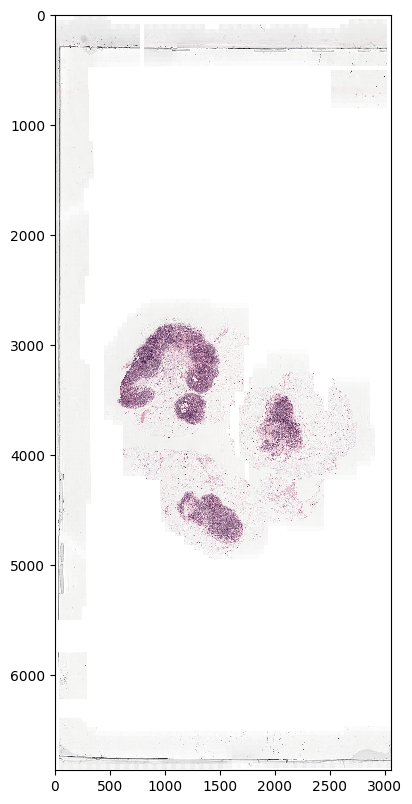

In [43]:
show_slide()

'mask'

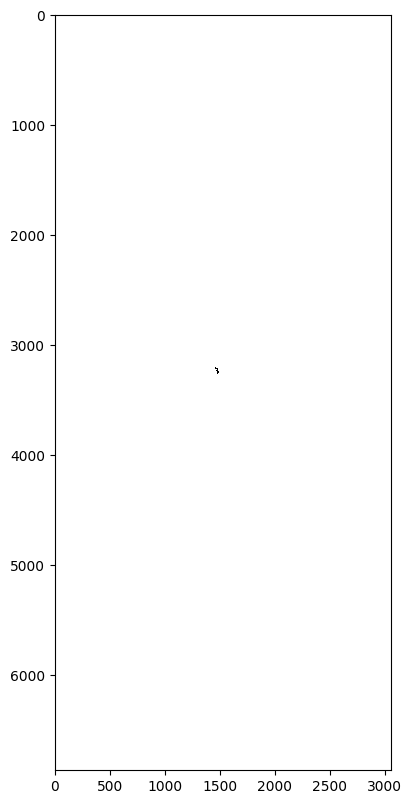

In [44]:
show_mask()

'overlay'

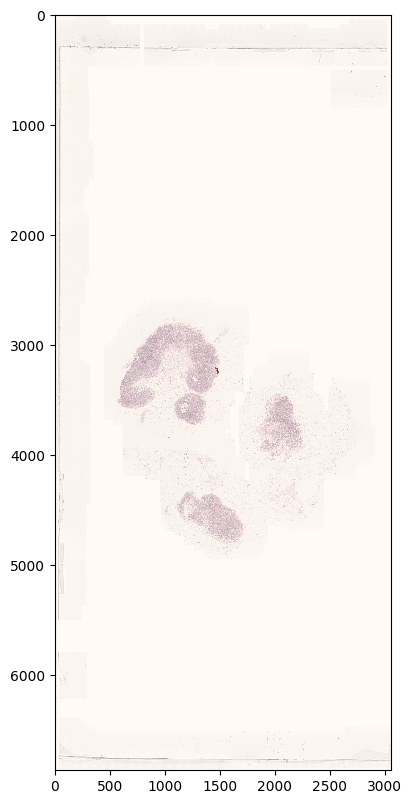

In [45]:
show_overlay(0.6)

In [46]:
df=pd.DataFrame(dat)
df

,downsample factor,image,level,max windows,x,y
0,1,002,0,240263,97792,219648
1,2,002,1,60065,48896,109824
2,4,002,2,15015,24448,54912
3,8,002,3,3753,12224,27456
4,16,002,4,938,6112,13728
5,32,002,5,234,3056,6864
6,64,002,6,58,1528,3432
7,128,002,7,14,764,1716
8,256,002,8,3,382,858


In [47]:
df['x'][5]

3056

In [0]:
#Note "actual dim" represents the dimensions on the slide image
#actual_dim = float(df['x'][4])
#downsample = float(df['x'][5])
#correction = (downsample/actual_dim) * int(df['downsample factor'][5])
#correction

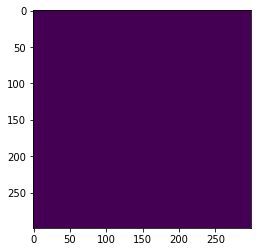

In [48]:
# Example: extract a (cancer) region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=(550*32), y=(1500*32), level=5, width=299, height=299)[:,:,0]
plt.imshow(region)

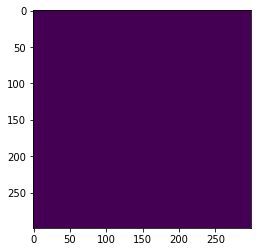

In [49]:
# Example: extract a (cancer) region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=(550*32), y=(1500*32), level=4, width=299, height=299)[:,:,0]
plt.imshow(region)

In [0]:
# THIS IS THE PROPER ADJUSTMENT TO SHOW THAT 32 FILTER IS THE CORRECT ONE TO USE WITH MAX AND MIN ACCORDINGLY

#region = read_slide(tumor_mask, x=(1400*32), y=(4500*32), level=5, width=299, height=299)[:,:,0]
#plt.imshow(region)

In [50]:
tissue_pixels = list(find_tissue_pixels(slide_image))
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

885130 tissue_pixels pixels (1.9 percent of the image)


In [51]:
mask_image.shape

(6864, 3056)

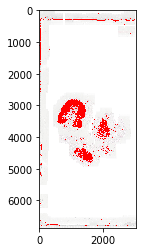

In [52]:
tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [53]:
tissue_regions.shape

(6864, 3056, 3)

## Modeling

### Sampling data 
* class balance vs over/undersampling

Creating the dataset and labels at level 5. There is room for conversation to be had around how to approach the imbalanced dataset. Random oversampling might not be the best choice. We might want to consider using class_weight='balanced' (if possible to use with deep learning models).

CG - either way, doesn't matter to me

What the paper says about sampling:

"Each slide contains 10,000 to 400, 000 patches (median 90,000). However, each tumor slide contains 20 to 150,000 tumors patches (median 2,000), corresponding to tumor patch percentages ranging from 0.01% to 70% (median 2%). Avoiding biases towards slides containing more patches (both normal and tumor) required careful sampling. First, we select “normal” or “tumor” with equal probability. Next, we select a slide that contains that class of patches uniformly at random, and sample patches from that slide. By contrast, some existing methods pre-sample a set of patches from each slide [23], which limits the breadth of patches seen during training."

And about data augmentation:

"First, we rotate the input patch by 4 multiples of 90 degrees, apply a left-right flip and repeat the rotations. All 8 orientations are valid because pathology slides do not have canonical orientations. Next, we use TensorFlow’s image library (tensorflow.image.random X ) to perturb color: brightness with a maximum delta of 64/255, saturation with a maximum delta of 0.25, hue with a maximum delta of 0.04, and contrast with a maximum delta of 0.75. Lastly, we add jitter to the patch extraction process such that each patch has a small x,y offset of up to 8 pixels. The magnitudes of the color perturbations and jitter were lightly tuned using our validation set. Pixel values are clipped to [0, 1] and scaled to [−1, 1]."

In [0]:
sample_images = random.sample(image_names, 10)

In [63]:
sample_images

['tumor_101',
 'tumor_016',
 'tumor_064',
 'tumor_001',
 'tumor_002',
 'tumor_096',
 'tumor_019',
 'tumor_035',
 'tumor_110',
 'tumor_081']

### Train/test split

In [64]:
data, labels =  create_dataset(3, sample_images)

data = np.asarray(data) / 255.0
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
print(np.bincount(y_train))

/content/gdrive/My Drive/tumor_data/tumor_101.tif
/content/gdrive/My Drive/tumor_data/tumor_101_mask.tif
opening slide & mask..
dims: 17408 8960
x steps: 58 y steps: 29
/content/gdrive/My Drive/tumor_data/tumor_016.tif
/content/gdrive/My Drive/tumor_data/tumor_016_mask.tif
opening slide & mask..
dims: 12224 27648
x steps: 40 y steps: 92
/content/gdrive/My Drive/tumor_data/tumor_064.tif
/content/gdrive/My Drive/tumor_data/tumor_064_mask.tif
opening slide & mask..
dims: 12224 27584
x steps: 40 y steps: 92
/content/gdrive/My Drive/tumor_data/tumor_001.tif
/content/gdrive/My Drive/tumor_data/tumor_001_mask.tif
opening slide & mask..
dims: 12224 27648
x steps: 40 y steps: 92
/content/gdrive/My Drive/tumor_data/tumor_002.tif
/content/gdrive/My Drive/tumor_data/tumor_002_mask.tif
opening slide & mask..
dims: 12224 27456
x steps: 40 y steps: 91
/content/gdrive/My Drive/tumor_data/tumor_096.tif
/content/gdrive/My Drive/tumor_data/tumor_096_mask.tif
opening slide & mask..
dims: 16384 8960
x step

In [65]:
len(X_train)

934

In [66]:
balance_ratio = np.bincount(y_train)[0]/np.bincount(y_train)[1]
balance_ratio

1.0304347826086957

In [0]:
#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
class_weights = {0: 1, 1: balance_ratio}

### Modeling - simple, dense network

starting with a dense model -- before trying even a CNN or a pre-trained model, for a baseline

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(299,299,3)))
#model.add(layers.Dense(128, activation=tf.nn.relu, input_dim = 299*299*3))
model.add(layers.Dense(128, activation=tf.nn.relu))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
          

In [0]:
model.compile(optimizer=optimizers.adam(lr=3e-5), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#note: learning rate chosen from best practice heuristic suggested here: http://karpathy.github.io/2019/04/25/recipe/

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 268203)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               34330112  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 34,330,241
Trainable params: 34,330,241
Non-trainable params: 0
_________________________________________________________________


In [75]:
history_baseline = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), batch_size = 40, class_weight = class_weights)
history_baseline

Instructions for updating:
Use tf.cast instead.
Train on 934 samples, validate on 104 samples
Epoch 1/10
934/934 [==============================] - 6s 7ms/step - loss: 1.9341 - acc: 0.5685 - val_loss: 0.6007 - val_acc: 0.7115
Epoch 2/10
934/934 [==============================] - 3s 3ms/step - loss: 0.6034 - acc: 0.6734 - val_loss: 0.6067 - val_acc: 0.7308
Epoch 3/10
934/934 [==============================] - 3s 3ms/step - loss: 0.5738 - acc: 0.7302 - val_loss: 0.6113 - val_acc: 0.7019
Epoch 4/10
934/934 [==============================] - 3s 3ms/step - loss: 0.5633 - acc: 0.7216 - val_loss: 0.5750 - val_acc: 0.7212
Epoch 5/10
934/934 [==============================] - 3s 3ms/step - loss: 0.5611 - acc: 0.7099 - val_loss: 0.6582 - val_acc: 0.6827
Epoch 6/10
934/934 [==============================] - 3s 3ms/step - loss: 0.5428 - acc: 0.7323 - val_loss: 0.5839 - val_acc: 0.7885
Epoch 7/10
934/934 [==============================] - 3s 3ms/step - loss: 0.5816 - acc: 0.6884 - val_loss: 0.5839 

In [76]:
test_loss_baseline, test_acc_baseline = model.evaluate(X_test, y_test)
print('')
print('Validation accuracy:', test_acc_baseline)

104/104 [==============================] - 0s 2ms/step

Validation accuracy: 0.7211538461538461


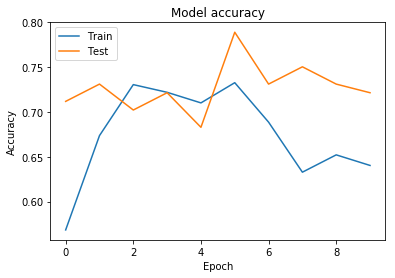

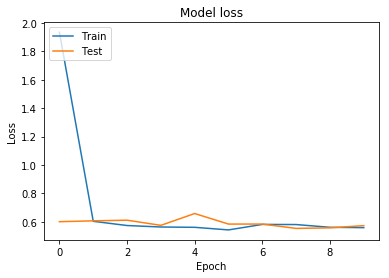

In [77]:
# Plot training & validation accuracy values
plt.plot(history_baseline.history['acc'])
plt.plot(history_baseline.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [0]:
y_pred_base = model.predict(X_test).ravel()
fpr_base, tpr_base, thresholds_base = roc_curve(y_test, y_pred_base)
auc_base = auc(fpr_base, tpr_base)

### Full baseline model with final evaluation completed
CG Notes
* Unclear why we are adding many more dense layers to a baseline model
* Baseline is intended to validate convergence and to get some non-trivial accuracy. This is achieved with a single hidden layer per above model, model_baseline
* IMO this additional dense model below should be foregone in favor of the basic CNN that follows

In [0]:
data, labels, references =  create_dataset_ref(5, image_names)
data = np.asarray(data) / 255.0 #need to verify rescaling value

In [0]:
# need to keep track of which images are assigned to which set
# we are working with 21 images. Suggesting using 3 images for testing and 18 images for training
test_ref = list(references.values())[:3] # using the first three images for testing
#computing cutoff length
test_image_names = list(references.keys())[:3] # we need this for visual interpretation in the end
test_window_count = 0
for im in test_ref:
  test_window_count += len(im[1])
X_test = data[:test_window_count]
X_train = data[test_window_count:]
y_test = labels[:test_window_count]
y_train = labels[test_window_count:]

In [0]:
balance_ratio = np.bincount(y_train)[0]/np.bincount(y_train)[1]
class_weights = {0: 1, 1: balance_ratio}
balance_ratio

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=(299,299,3)))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.5))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dense(64, activation=tf.nn.relu))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(optimizer=optimizers.adam(lr=3e-5), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model_baseline.summary()

In [0]:
history = model_baseline.fit(X_train, y_train, epochs = 20, validation_split=0.2, batch_size = 20, class_weight = class_weights)

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# inspecting ROC AUC score on hold out test dataset
y_pred = model_baseline.predict(X_test)
final_pred = []
for point in y_pred:
  if point > 0.5:
    final_pred.append(1)
  else:
    final_pred.append(0)
test_score = roc_auc_score(y_test, final_pred)
print('Final hold-out test set ROC AUC score: {}'.format(test_score))

In [0]:
y_pred

array([[0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.47784242],
       [0.54275185],
       [0.477

In [0]:
# TODO create function to reconstruct model prediction into an image (concatanate windows using references)
# start by creating an empty figure with proper shape
slide_image.shape() # copy the test image shape and fill with zeros
# then we need to go window by window using the references generated (second value) and use the final_pred labels to create shading in those windows

In [0]:
#create placeholder params 
model_l = slide_image.shape[0]
model_w = slide_image.shape[1]
model_c = slide_image.shape[2]

# create empty image placeholder
placeholder = np.zeros((model_l, model_w, model_c))

#saniy check 
assert slide_image.shape == placeholder.shape

# now filling in placeholder with predictions window by window
placeholder[0]

In [0]:
#testing
placeholder[100:900] = np.ones((800, 3056,3))

# this approach works, so now we just need to write a function that would turn positive windows into 1 in our placeholder (the math might be tricky)

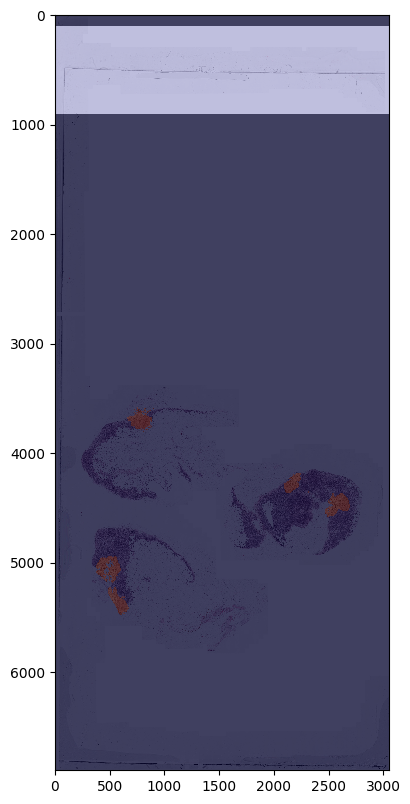

In [0]:
# the test version works!
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)
plt.imshow(placeholder, cmap='viridis', alpha=0.5)

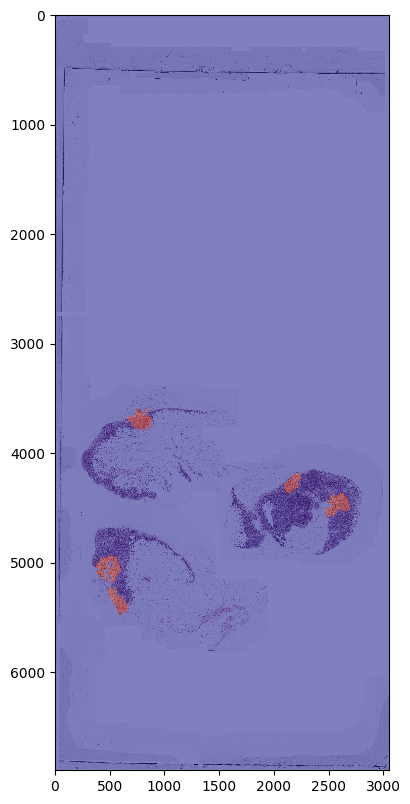

In [0]:
# overlayering the test set image with the mask vs model prediction
#plotting the entire test image at zoom level 5
test_name = test_image_names[0]
test_path = os.path.join(SLIDES_DIR, test_name+'.tif')
mask_test_path =  os.path.join(SLIDES_DIR, test_name+'_mask.tif')
slide = open_slide(test_path)
tumor = open_slide(mask_test_path)
# showing the entire test image at chosen zoom level
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])
# showing the mask for test image at chosen level
mask_image = read_slide(tumor, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])[:,:,0]
# showing the model predictions for test image at chosen level
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)
#plt.imshow(model_image, cmap='jet', alpha=0.5) # would need to choose appropriate color - possibly blue?
# MISSING THE MODEL_IMAGE VIEW FROM ABOVE

In [0]:
final_pred[1]

0

In [0]:
def run_inference(level, image_name, model=None):
    
    #reading in the slides and masks B@ODW
    slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
    print(slide_path)
    print(tumor_mask_path)

    #opening them
    print('opening slide & mask..')
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    
    predicted_mask = np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]))
    print('predicted mask shape: ' + str(predicted_mask.shape))
    
    slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
    # showing the mask for test image at chosen level
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

    #dimensions at chosen level
    x_max = slide.level_dimensions[level][0]
    y_max = slide.level_dimensions[level][1] 
    print('dims: ' + str(x_max) + ' ' + str(y_max))

    #sanity check  
    assert tumor_mask.level_dimensions[level][0] == x_max
    assert tumor_mask.level_dimensions[level][1] == y_max

    # choosing downsample factor
    downsample_factor = int(slide.level_downsamples[level])

    #initiatize coordinates
    x0 = 0 #int(.05*x_max) possibility to create padding
    y0 = 0 #int(.05*y_max) possibility to create padding

    #size of window
    x_dim, y_dim = 299., 299.
    size = (int(x_dim), int(y_dim))

    #calculate how many steps we can take with 299x299 window
    #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
    x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim)) # I don't think we need the -1 above since int() already rounds down
    print('x steps: '+ str(x_steps) + 'y steps: '+ str(y_steps))

    for i in range(x_steps):
        for j in range(y_steps): 
            #generating a window from the original slide
            window = read_slide(slide, 
                             x=int(x0)*downsample_factor, 
                             y=int(y0)*downsample_factor, 
                             level=level, 
                             width=int(x_dim), 
                             height=int(y_dim))
            #conducting sanity check
            assert window.shape == (x_dim, y_dim, 3)

            if is_tissue_in_window(window) is True:
              if model is not None:
                window_reshaped = window.reshape(1, 299, 299, 3)
                pred = model.predict(window_reshaped)
                if pred > 0.5:
                  predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = 1

              else:
                # Just for testing--if our predictions were to match the true labels exactly, the colored windows
                # in our predicted_mask should overlap with the true mask at the end
                window_mask = read_slide(tumor_mask, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))[:,:,0]
                if np.count_nonzero(window_mask.flatten()) > 0: # contains cancer
                  predicted_mask[int(y0):(int(y0) + int(y_dim)), int(x0):(int(x0) + int(x_dim))] = 1

            #move the sliding window on y axis
            y0 = y0 + y_dim

        #move the sliding window on x axis
        x0 = x0 + x_dim
        # reset y0 to start
        y0 = 0 #int(.05*y_max) if using padding

    return predicted_mask, slide_image, mask_image

In [0]:
# test version - if no model passed in, outputs the mask we'd get at this level if our model perfectly predicted the true labels
# real version should be something like predicted_mask = run_inference(5, 'tumor_084', model_baseline)
predicted_mask = run_inference(5, 'tumor_084')

/mnt/gdrive/My Drive/slides/tumor_084.tif
/mnt/gdrive/My Drive/slides/tumor_084_mask.tif
opening slide & mask..
predicted mask shape: (2688, 2048)
dims: 2048 2688
x steps: 6y steps: 8


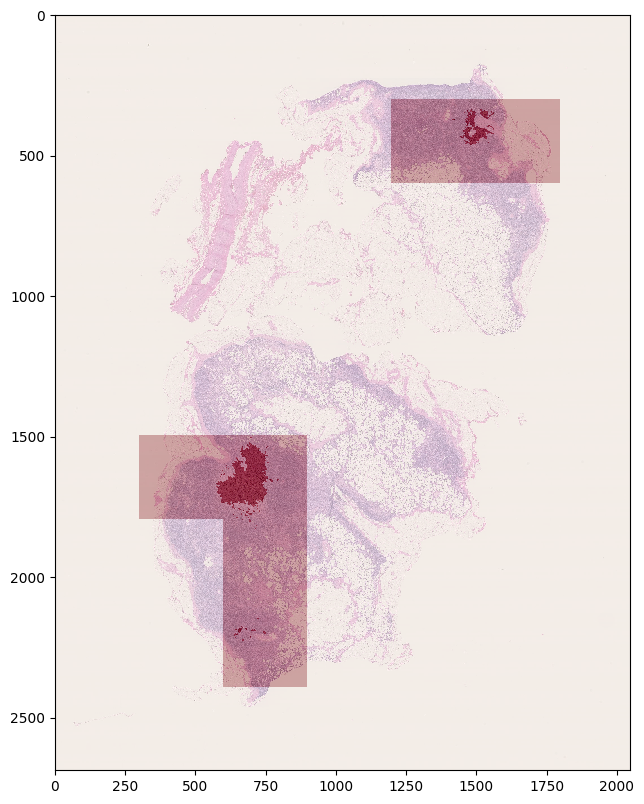

In [0]:
# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask, cmap='OrRd', alpha=0.3)

### Transfer Learning

In [0]:
from keras.applications.inception_v3 import InceptionV3

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam

In [0]:
# using inception
inception = InceptionV3(weights='imagenet',include_top=False, input_shape=(299, 299, 3))

In [0]:
inception.trainable = False

CG Note, prior implementation of transfer learning

NOTE: Wrong number of outputs used in final layer.. should be 1 for binary classification, not 2

* This was fixed in below implementation
* While I understand we 'can' use softmax & sparse_categorical_entropy akin to multi-caregorical classification for binary classification, it's not a good idea. 1) because it's confusing for those that are trying to follow our code, and 2 because it produces logits in the output layer rather than a binary classification. This causes problems when trying to display/interpret results of binary classification exercises

In [0]:
'''#reshaping the data
X_train = X_train.reshape(X_train.shape[0], 299, 299, 3)

# setting up the model
EPOCHS = 5

model_inception = Sequential()
model_inception.add(inception)
model_inception.add(Flatten())
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dense(2, activation='softmax'))
model_inception.add(Dense(1, activation='softmax'))

model_inception.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) 
                      #,auc_roc]) #potentially might want to use roc_auc for metrics

history_inception = model_inception.fit(
      X_train, y_train,
      epochs=EPOCHS,
      validation_split=0.1,
      verbose=1,
      shuffle=True,
      batch_size=16)'''

CG implementation, transfer learning with inceptionv3

In [105]:
#inception transfer learning

model_inc = Sequential()
model_inc.add(inception)

#use same dense setup as dense baseline above for comparison
model_inc.add(Flatten())
model_inc.add(Dense(128, activation=tf.nn.relu))
model_inc.add(Dropout(0.5))
model_inc.add(Dense(1, activation='sigmoid'))

"model_inception.compile(loss='sparse_categorical_crossentropy',\n              optimizer='adam',\n              metrics=['accuracy']) \n                      #,auc_roc]) #potentially might want to use roc_auc for metrics"

In [0]:
# Set Optimizer
opt = adam(lr=3e-5)
  
model_inc.compile(optimizer=opt, 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#note: learning rate chosen from best practice heuristic suggested here: http://karpathy.github.io/2019/04/25/recipe/

In [107]:
#batch size of 40 used to be consistent with baseline. 
#epochs defined here rather than in main model setup cell
history_inception = model_inc.fit(
      X_train, y_train,
      epochs=10,
      validation_split=0.1,
      verbose=1,
      shuffle=True,
      batch_size=40)

Train on 840 samples, validate on 94 samples
Epoch 1/10
840/840 [==============================] - 20s 23ms/step - loss: 0.6255 - acc: 0.7060 - val_loss: 0.4755 - val_acc: 0.7340
Epoch 2/10
840/840 [==============================] - 5s 6ms/step - loss: 0.2907 - acc: 0.8786 - val_loss: 0.4188 - val_acc: 0.8085
Epoch 3/10
840/840 [==============================] - 5s 6ms/step - loss: 0.2105 - acc: 0.9107 - val_loss: 0.4315 - val_acc: 0.7872
Epoch 4/10
840/840 [==============================] - 5s 6ms/step - loss: 0.1607 - acc: 0.9417 - val_loss: 0.4145 - val_acc: 0.8298
Epoch 5/10
840/840 [==============================] - 5s 6ms/step - loss: 0.1158 - acc: 0.9583 - val_loss: 0.4622 - val_acc: 0.7872
Epoch 6/10
840/840 [==============================] - 5s 6ms/step - loss: 0.1169 - acc: 0.9595 - val_loss: 0.4341 - val_acc: 0.7766
Epoch 7/10
840/840 [==============================] - 5s 6ms/step - loss: 0.1002 - acc: 0.9702 - val_loss: 0.4489 - val_acc: 0.8085
Epoch 8/10
840/840 [=========

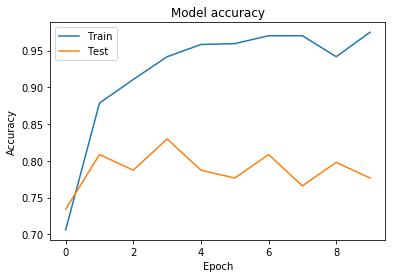

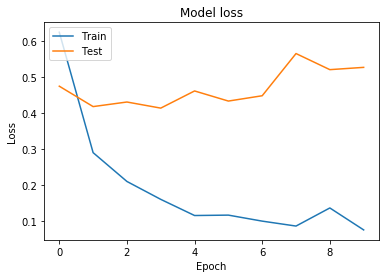

In [108]:
# Plot training & validation accuracy values
plt.plot(history_inception.history['acc'])
plt.plot(history_inception.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Given that we are overfitting quickly, there is additional room to add dense layers and/or improve our CNN architecture.
* However, we do achieve pretty good results with this simple approach leveraging transfer learning

Re this approach to ROC: I didn't try to debug this but clearly there's something wrong here- the AUC can't be 0.5 if we're achieving some reasonable level of accuracy with a balanced dataset

In [104]:
'''# inspecting ROC AUC score on hold out test dataset
X_test = X_test.reshape(X_test.shape[0], 299, 299, 3)
y_pred = model_inc.predict(X_test, batch_size=None)
final_pred = []
for point in y_pred:
  final_pred.append(np.argmax(point))
test_score = roc_auc_score(y_test, final_pred)
print(test_score)'''

0.5


Instead, implemented this AUC/ROC graphic: https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

### ROC graphic - comparison of baseline & inception model

In [0]:
y_pred_inc = model_inc.predict(X_test).ravel()
fpr_inc, tpr_inc, thresholds_inc = roc_curve(y_test, y_pred_inc)
auc_inc = auc(fpr_inc, tpr_inc)

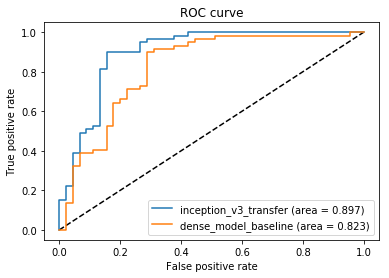

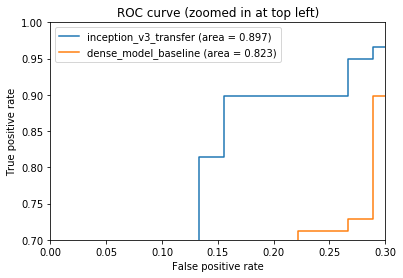

In [148]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### Confusion Matrices

(FIXED but read anyway) 
Note: for some reason we are outputing our predictions as floats, as though we are using softmax. This is causing problems when analyzing results as a confusion matrix.. as we can't mix binary and continuous targets. 
* Unclear to me why the predictions are being produced as continous rather than binary since I have implemented with sigmoid.. could use a second set of eyes
* UPDATE: resolved by rounding.. looks good

In [139]:
y_pred_inc.shape

(104,)

In [146]:
rounded_pred = np.round(y_pred_inc)
cf = confusion_matrix(y_test, rounded_pred)
cf

array([[31, 14],
       [ 2, 57]])

Looks very good! Only two false negatives, which is exactly the type of result we want :)

In [0]:
import itertools

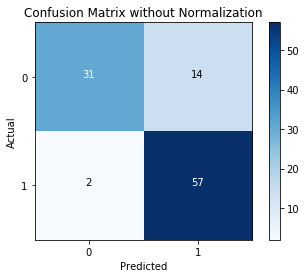

In [147]:
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

Again.. not bad! much better to have false positives when designing a reasonable recommendation system than false negatives. 

## Modeling 2: Downloading and Creating Dataset With Train/Test Split

In [0]:
# classifying which images have cancer
image_classes = tumor_classification(image_names)

In [0]:
image_classes

{'tumor_001': 1,
 'tumor_002': 1,
 'tumor_005': 1,
 'tumor_012': 1,
 'tumor_016': 1,
 'tumor_019': 1,
 'tumor_023': 1,
 'tumor_031': 1,
 'tumor_035': 1,
 'tumor_057': 1,
 'tumor_059': 1,
 'tumor_064': 1,
 'tumor_075': 1,
 'tumor_078': 1,
 'tumor_081': 1,
 'tumor_084': 1,
 'tumor_091': 1,
 'tumor_094': 1,
 'tumor_096': 1,
 'tumor_101': 1,
 'tumor_110': 1}

It appears that all images in the dataset actually have at least a tiny bit of of area classified as cancer! 

Having created a list of image name references, we will now split the images randomly into train and test groups and generate the trainig dataset accordingly.

### Create training/test splits

In [0]:
# randomly choosing three images from the original list to treat as a test set
random.shuffle(image_names)
train_names = image_names[3:]
test_names = image_names[:3]
print("Images chosen for testing:{}".format(test_names))

Images chosen for testing:['tumor_012', 'tumor_091', 'tumor_005']


In [0]:
# creating the training dataset for future model development (no data augmentation by default)
X_train, y_train = create_dataset(3, train_names, with_augmentation=False)

/content/gdrive/My Drive/tumor_data/tumor_096.tif
/content/gdrive/My Drive/tumor_data/tumor_096_mask.tif
opening slide & mask..
dims: 16384 8960
x steps: 54y steps: 29
/content/gdrive/My Drive/tumor_data/tumor_084.tif
/content/gdrive/My Drive/tumor_data/tumor_084_mask.tif
opening slide & mask..
dims: 8192 10752
x steps: 27y steps: 35
/content/gdrive/My Drive/tumor_data/tumor_002.tif
/content/gdrive/My Drive/tumor_data/tumor_002_mask.tif
opening slide & mask..
dims: 12224 27456
x steps: 40y steps: 91
/content/gdrive/My Drive/tumor_data/tumor_064.tif
/content/gdrive/My Drive/tumor_data/tumor_064_mask.tif
opening slide & mask..
dims: 12224 27584
x steps: 40y steps: 92
/content/gdrive/My Drive/tumor_data/tumor_081.tif
/content/gdrive/My Drive/tumor_data/tumor_081_mask.tif
opening slide & mask..
dims: 11264 12544
x steps: 37y steps: 41
/content/gdrive/My Drive/tumor_data/tumor_057.tif
/content/gdrive/My Drive/tumor_data/tumor_057_mask.tif
opening slide & mask..
dims: 12224 27584
x steps: 40

We will be working with 2044 windows as our train dataset.
-
Train label class distribution is as follows:


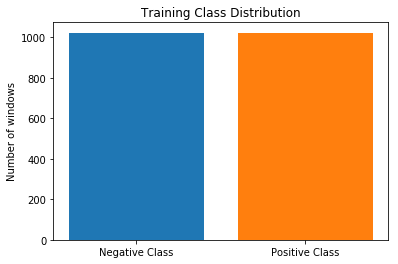

In [0]:
# checking the resulting shape and label distribution
print('We will be working with {} windows as our train dataset.'.format(len(X_train)))
print('-')
print('Train label class distribution is as follows:')
plt.bar(0, np.bincount(y_train)[0])
plt.bar(1, np.bincount(y_train)[1])
plt.xticks([0,1], labels = ('Negative Class', 'Positive Class'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution')
plt.show()

We will be working with 1817 windows as our train dataset.
-
Train label class distribution is as follows:


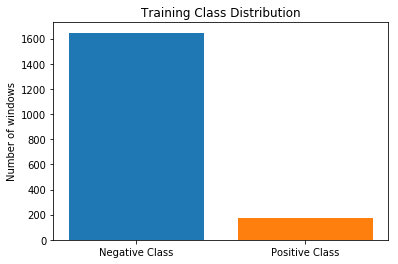

In [0]:
# checking the resulting shape and label distribution
print('We will be working with {} windows as our train dataset.'.format(len(X_train)))
print('-')
print('Train label class distribution is as follows:')
plt.bar(0, np.bincount(y_train)[0])
plt.bar(1, np.bincount(y_train)[1])
plt.xticks([0,1], labels = ('Negative Class', 'Positive Class'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution')
plt.show()

Looking at the class distribution above, we can see that the data is heavily skewed towards negative class. Therefore, it is important to address this class imbalance before fitting any models. Otherwise, using the default accuracy metrics will be misleading.

##### Note: class imbalance will not just affect what accuracy metrics we use. If the data is heavily imbalanced, the model will train to this result.

### Data Preprocessing & Class Balance

In order to address the class imbalance, we have considered two approaches. 

1. Applying class weights inside the model. According to Keras documentation: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
2. Using the same sampling technique as the research paper: "Avoiding biases towards slides containing more patches (both normal and tumor) required careful sampling. First, we select “normal” or “tumor” with equal probability. Next, we select a slide that contains that class of patches uniformly at random, and sample patches from that slide."

In [0]:
# calculating the balance ratio for the first approach
balance_ratio = np.bincount(y_train)[0]/np.bincount(y_train)[1]
print('Resulting balance ratio found: {} %'.format(np.round(balance_ratio, 2)))

Resulting balance ratio found: 9.8 %


In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print('Calculated class weights: 0: {}, 1: {}'.format(class_weights[0], class_weights[1]))

Calculated class weights: 0: 0.5510462904248573, 1: 5.39751552795031


For the data baseline preprocessing, we would simply be rescaling the training images by dividing by 255.

In [0]:
# rescaling the training dataset per standard practice
X_train = np.asarray(X_train) / 255.0 # VERIFY THAT THIS IS CORRECT

In [0]:
# TO DO: IMPLEMENT THE RESEARCH PAPER SAMPLING TECHNIQUE
X_train_os = X_train.reshape(X_train.shape[0], 299*299*3)
ros = RandomOverSampler(random_state=42, sampling_strategy={0:1620, 1:800})
X_train_os, y_train_os = ros.fit_resample(X_train_os, y_train)


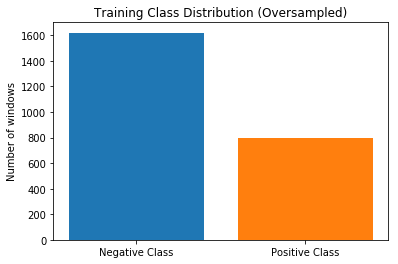

In [0]:
# new balanced dataset
plt.bar(0, np.bincount(y_train_os)[0])
plt.bar(1, np.bincount(y_train_os)[1])
plt.xticks([0,1], labels = ('Negative Class', 'Positive Class'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution (Oversampled)')
plt.show()

## Modeling

For modeling we decided to approach the problem by first working on a simple baseline model. Then, we have tried transfer learning -pretrained model on ImageNet to see if it would beat the baseline. Lastly, we have developed our own model guided by the research paper findings. Within the last model architecture, we applied data augmentation to attempt to increase model performance and forecastability.

### Baseline Model - with data augmentation

For the baseline model, we chose a simple DNN with some dropout added to avoid early overfitting.

In [0]:
model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=(299,299,3))) 
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.5))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(optimizer=optimizers.adam(lr=3e-5), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Let us look at the model summary:

In [0]:
model_baseline.summary()

In [0]:
# working with augmented dataset
history_baseline = model_baseline.fit(X_train_os, y_train_os, epochs = 5, validation_split=0.2, batch_size = 20)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1936 samples, validate on 484 samples
Epoch 1/5
1936/1936 [==============================] - 20s 10ms/step - loss: 2.6161 - acc: 0.8311 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/5
1936/1936 [==============================] - 14s 7ms/step - loss: 2.6308 - acc: 0.8368 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/5
1936/1936 [==============================] - 13s 7ms/step - loss: 2.6308 - acc: 0.8368 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/5
1936/1936 [==============================] - 13s 7ms/step - loss: 2.6308 - acc: 0.8368 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/5
1936/1936 [==============================] - 13s 7ms/step - loss: 2.6308 - acc: 0.8368 - val_loss: 16.1181 - val_acc: 0.0000e+00


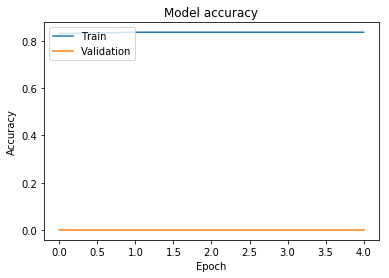

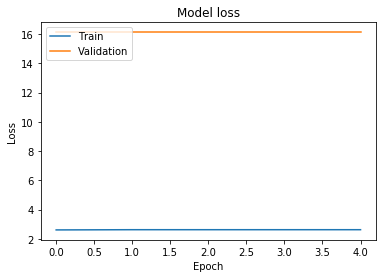

In [0]:
# Plot training & validation accuracy values
plt.plot(history_baseline.history['acc'])
plt.plot(history_baseline.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Baseline Model - Experiments

For the baseline model, we chose a simple DNN with some dropout added to avoid early overfitting.

In [0]:
model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=(299,299,3)))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.5))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.5))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(optimizer=optimizers.adam(), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let us look at the model summary:

In [0]:
model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 268203)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               137320448 
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
__________

In [0]:
BATCH = 16
train_steps = int(np.ceil(X_train.shape[0]*0.8 / BATCH))
val_steps = int(np.ceil(X_train.shape[0]*0.2 / BATCH))
history_baseline = model_baseline.fit(X_train, y_train, epochs = 10, validation_split=0.2, 
                                      steps_per_epoch=train_steps, validation_steps=val_steps,
                                      shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 1635 samples, validate on 409 samples
Epoch 1/10
103/103 [==============================] - 154s 1s/step - loss: 7.4719 - acc: 0.5270 - val_loss: 9.7058 - val_acc: 0.3912
Epoch 2/10
103/103 [==============================] - 148s 1s/step - loss: 7.5373 - acc: 0.5272 - val_loss: 9.7058 - val_acc: 0.3912
Epoch 3/10
103/103 [==============================] - 149s 1s/step - loss: 7.5373 - acc: 0.5272 - val_loss: 9.7058 - val_acc: 0.3912
Epoch 4/10
103/103 [==============================] - 150s 1s/step - loss: 7.5373 - acc: 0.5272 - val_loss: 9.7058 - val_acc: 0.3912
Epoch 5/10
103/103 [==============================] - 150s 1s/step - loss: 7.5373 - acc: 0.5272 - val_loss: 9.7058 - val_acc: 0.3912
Epoch 6/10
103/103 [==============================] - 149s 1s/step - loss: 7.5373 - acc: 0.5272 - val_loss: 9.7058 - val_acc: 0.3912
Epoch 7/10
103/103 [==============================] - 149s 1s/step - loss: 7.5373 - acc: 0.5272 - val_loss:

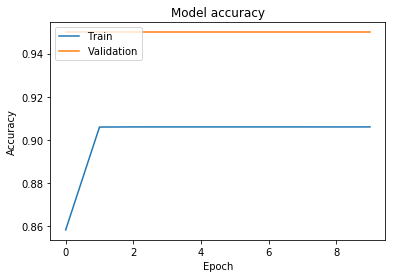

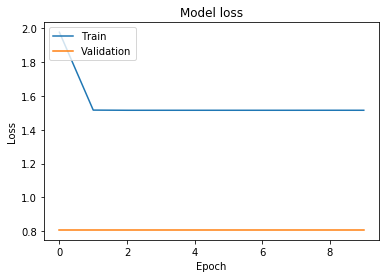

In [0]:
# Plot training & validation accuracy values
plt.plot(history_baseline.history['acc'])
plt.plot(history_baseline.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# creating text_dataset for fitting the model
X_test, y_test = create_dataset_test(level = 5, image_names = test_names)

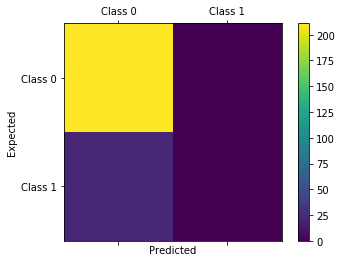

In [0]:
# outputting the confusion matrix
X_test = np.asarray(X_test) / 255.0
y_pred = model_baseline.predict(X_test)
final_pred = []
for point in y_pred:
  if point > 0.5:
    final_pred.append(1)
  else:
    final_pred.append(0)
conf_mat = confusion_matrix(y_true=y_test, y_pred=final_pred)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat) #, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [0]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_test, final_pred)
print(roc_auc_baseline)

0.5


In [0]:
# checking how many pos labels were predicted
sum(final_pred)

0

In [0]:
# inspecting prediction mask for a single test image
predicted_mask, slide_image, mask_image = run_inference(5, test_names[0], model_baseline)

/content/gdrive/My Drive/tumor_data/tumor_035.tif
/content/gdrive/My Drive/tumor_data/tumor_035_mask.tif
opening slide & mask..
predicted mask shape: (6912, 3056)
dims: 3056 6912
x steps: 10y steps: 23


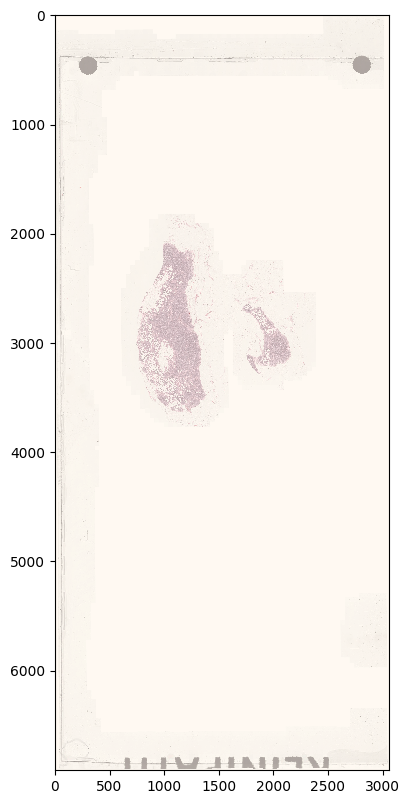

In [0]:
# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_084.tif
/content/gdrive/My Drive/tumor_data/tumor_084_mask.tif
opening slide & mask..
predicted mask shape: (2688, 2048)
dims: 2048 2688
x steps: 6y steps: 8


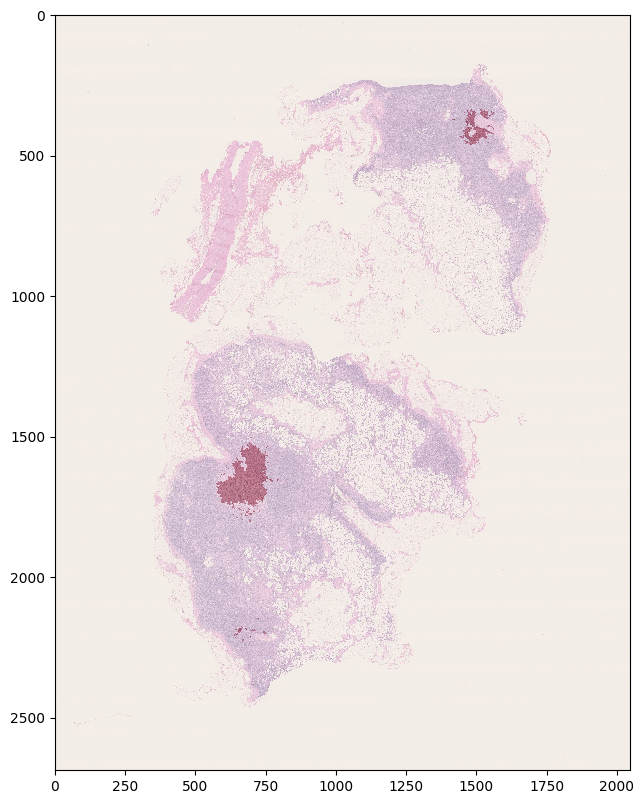

In [0]:
# another try with a different test image
predicted_mask2, slide_image2, mask_image2 = run_inference(5, test_names[1], model_baseline)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image2)
plt.imshow(mask_image2, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask2, cmap='OrRd', alpha=0.3)
plt.show()

### CNN Model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

IMAGE_SIZE = 299

model_CNN = Sequential()
model_CNN.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model_CNN.add(Conv2D(first_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(MaxPool2D(pool_size = pool_size)) 
model_CNN.add(Dropout(dropout_conv))

model_CNN.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(MaxPool2D(pool_size = pool_size))
model_CNN.add(Dropout(dropout_conv))

model_CNN.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(MaxPool2D(pool_size = pool_size))
model_CNN.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model_CNN.add(Flatten())
model_CNN.add(Dense(256, use_bias=False))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation("relu"))
model_CNN.add(Dropout(dropout_dense))
model_CNN.add(Dense(1, activation = "sigmoid"))

# Compile the model
model_CNN.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [0]:
BATCH = 32
train_steps = int(np.ceil(X_train.shape[0]*0.8 / BATCH))
val_steps = int(np.ceil(X_train.shape[0]*0.2 / BATCH))
history_CNN = model_CNN.fit(X_train, y_train, epochs = 6, validation_split=0.2, batch_size=32,
                                      class_weight = class_weights, shuffle=True)

Train on 1390 samples, validate on 348 samples
Epoch 1/10
1390/1390 [==============================] - 20s 14ms/step - loss: 0.3795 - acc: 0.8813 - val_loss: 1.0911 - val_acc: 0.8161
Epoch 2/10
1390/1390 [==============================] - 17s 13ms/step - loss: 0.2821 - acc: 0.8986 - val_loss: 0.5055 - val_acc: 0.8707
Epoch 3/10
1390/1390 [==============================] - 17s 12ms/step - loss: 0.2442 - acc: 0.9036 - val_loss: 0.6080 - val_acc: 0.8764
Epoch 4/10
1390/1390 [==============================] - 17s 12ms/step - loss: 0.2308 - acc: 0.9108 - val_loss: 0.6822 - val_acc: 0.8707
Epoch 5/10
1390/1390 [==============================] - 17s 12ms/step - loss: 0.2390 - acc: 0.9094 - val_loss: 0.3560 - val_acc: 0.8764
Epoch 6/10
1390/1390 [==============================] - 17s 12ms/step - loss: 0.2201 - acc: 0.9129 - val_loss: 0.2655 - val_acc: 0.9052
Epoch 7/10
1390/1390 [==============================] - 17s 12ms/step - loss: 0.2191 - acc: 0.9137 - val_loss: 3.3616 - val_acc: 0.1236
E

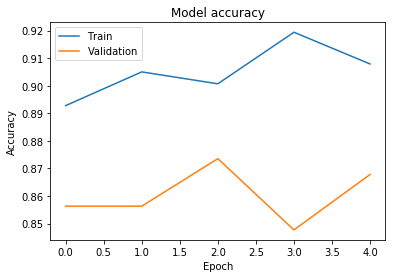

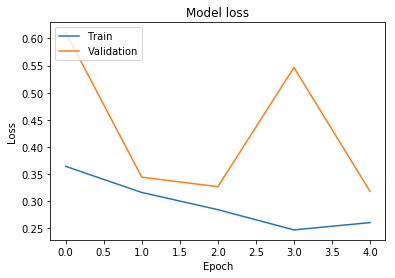

In [0]:
# Plot training & validation accuracy values
plt.plot(history_CNN.history['acc'])
plt.plot(history_CNN.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# creating text_dataset for fitting the model
X_test, y_test = create_dataset_test(level = 5, image_names = test_names)

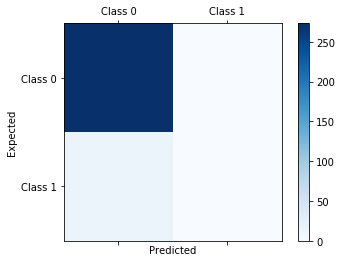

In [0]:
# outputting the confusion matrix
X_test = np.asarray(X_test) / 255.0
y_pred = model_CNN.predict(X_test)
final_pred = []
for point in y_pred:
  if point > 0.5:
    final_pred.append(1)
  else:
    final_pred.append(0)
conf_mat = confusion_matrix(y_true=y_test, y_pred=final_pred)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [0]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_test, final_pred)
print(roc_auc_baseline)

0.5


In [0]:
# looking at total positive
sum(final_pred)

0

### Baseline Model

For the baseline model, we chose a simple DNN with some dropout added to avoid early overfitting.

In [0]:
model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=(299,299,3)))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.5))
model_baseline.add(layers.Dense(64, activation=tf.nn.relu))
model_baseline.add(layers.Dense(32, activation=tf.nn.relu))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(optimizer=optimizers.adam(lr=3e-5), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Let us look at the model summary:

In [0]:
model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 268203)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               137320448 
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
__________

In [0]:
history_baseline = model_baseline.fit(X_train, y_train, epochs = 10, validation_split=0.2, batch_size = 64, class_weight = class_weights)

Train on 1420 samples, validate on 355 samples
Epoch 1/10


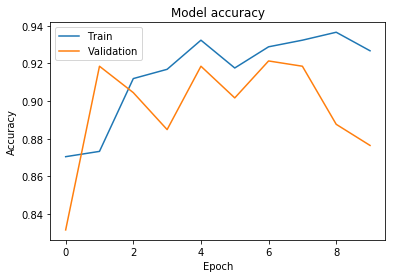

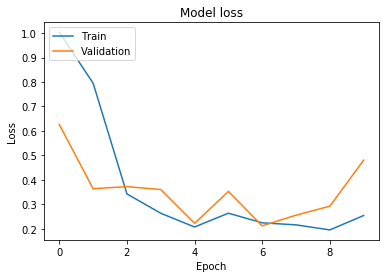

In [0]:
# Plot training & validation accuracy values
plt.plot(history_baseline.history['acc'])
plt.plot(history_baseline.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# creating text_dataset for fitting the model
X_test, y_test = create_dataset_test(level = 5, image_names = test_names)

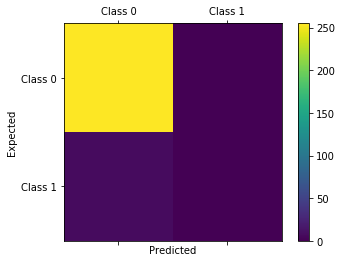

In [0]:
# outputting the confusion matrix
X_test = np.asarray(X_test) / 255.0
y_pred = model_baseline.predict(X_test)
final_pred = []
for point in y_pred:
  if point > 0.5:
    final_pred.append(1)
  else:
    final_pred.append(0)
conf_mat = confusion_matrix(y_true=y_test, y_pred=final_pred)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat) #, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [0]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_test, final_pred)
print(roc_auc_baseline)

0.5


In [0]:
# checking how many pos labels were predicted
sum(final_pred)

0

In [0]:
# inspecting prediction mask for a single test image
predicted_mask, slide_image, mask_image = run_inference(5, test_names[0], model_baseline)

/content/gdrive/My Drive/tumor_data/tumor_035.tif
/content/gdrive/My Drive/tumor_data/tumor_035_mask.tif
opening slide & mask..
predicted mask shape: (6912, 3056)
dims: 3056 6912
x steps: 10y steps: 23


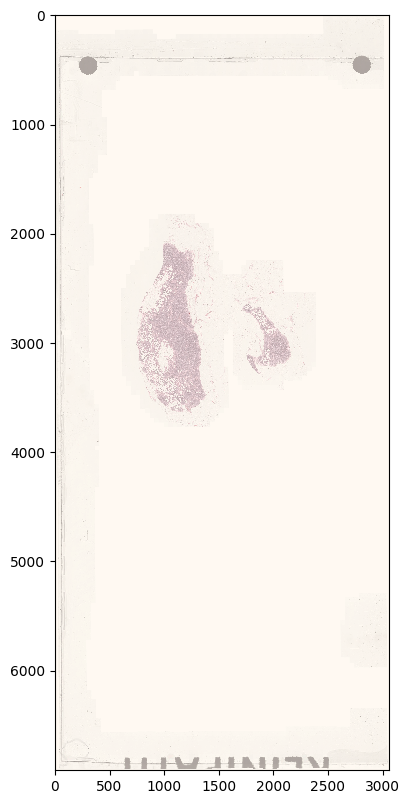

In [0]:
# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask, cmap='OrRd', alpha=0.3)
plt.show()

/content/gdrive/My Drive/tumor_data/tumor_084.tif
/content/gdrive/My Drive/tumor_data/tumor_084_mask.tif
opening slide & mask..
predicted mask shape: (2688, 2048)
dims: 2048 2688
x steps: 6y steps: 8


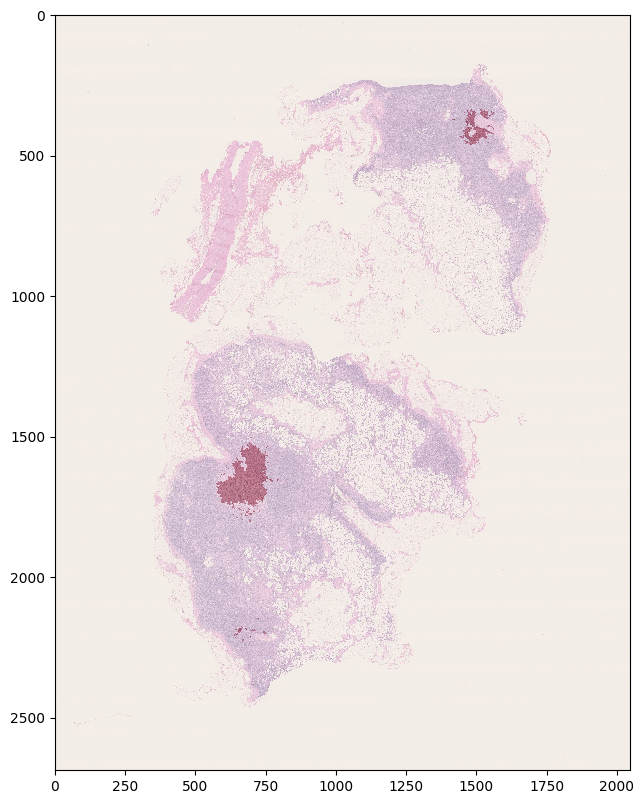

In [0]:
# another try with a different test image
predicted_mask2, slide_image2, mask_image2 = run_inference(5, test_names[1], model_baseline)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image2)
plt.imshow(mask_image2, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask2, cmap='OrRd', alpha=0.3)
plt.show()

### Transfer Learning Model

Having created the baseline, we wanted to also asses potential performance of a pre-trained model in classifying the dataset. We chose inception trained on ImageNet as our test model.

In [0]:
# using inception
inception = InceptionV3(weights='imagenet',include_top=False, input_shape=(299, 299, 3))
inception.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 8s 0us/step


In [0]:
# setting up the model
model_inception = Sequential()
model_inception.add(inception)
model_inception.add(Flatten())
model_inception.add(Dense(128, activation='relu'))
model_inception.add(Dense(1, activation='sigmoid'))

model_inception.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history_inception = model_inception.fit(
      X_train, y_train,
      epochs=3,
      validation_split=0.2,
      verbose=1,
      shuffle=True,
      batch_size=32, class_weight = class_weights)

Train on 1320 samples, validate on 331 samples
Epoch 1/3
1320/1320 [==============================] - 16s 12ms/sample - loss: 1.2601 - acc: 0.9152 - val_loss: 2.5321 - val_acc: 0.8429
Epoch 2/3
1320/1320 [==============================] - 10s 8ms/sample - loss: 1.3310 - acc: 0.9174 - val_loss: 2.5321 - val_acc: 0.8429
Epoch 3/3
1320/1320 [==============================] - 10s 7ms/sample - loss: 1.3310 - acc: 0.9174 - val_loss: 2.5321 - val_acc: 0.8429


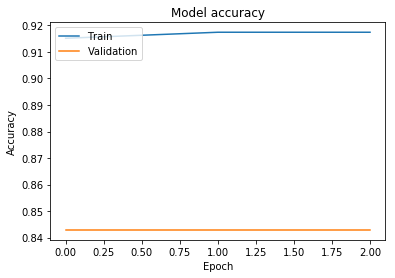

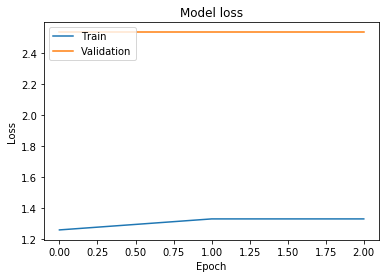

In [0]:
# Plot training & validation accuracy values
plt.plot(history_inception.history['acc'])
plt.plot(history_inception.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [0]:
# creating text_dataset for fitting the model
X_test, y_test = create_dataset_test(level = 5, image_names = test_names)

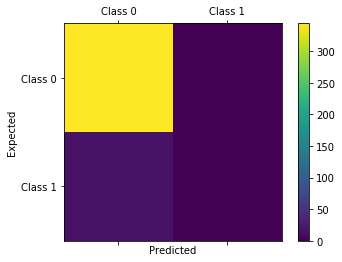

In [0]:
# outputting the confusion matrix
X_test = np.asarray(X_test) / 255.0
y_pred = model_inception.predict(X_test)
final_pred = []
for point in y_pred:
  if point > 0.5:
    final_pred.append(1)
  else:
    final_pred.append(0)
conf_mat = confusion_matrix(y_true=y_test, y_pred=final_pred)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat) #, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [0]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_test, final_pred)
print(roc_auc_baseline)

0.5


## The following is an mvp for creating training data from a single slide, at zoom level 5

In [0]:
# x dimensions from 0 to 500 are slide artifacts
#500./x_max
#y dimensions from 0 to ~1000 are slide artifacts
#1000./y_max

#### Create training data - sliding window pseudocode

for window in image:

	if window contains tissue:
		append window to train_set

		if window contains cancer:
			label = 1
		else:
			label = 0

In [0]:
def is_tissue_in_window(window, intensity=0.8):
  im_gray = rgb2gray(window)
  x_indices = np.where(im_gray <= intensity)[0]
  return len(x_indices) > 0

In [0]:
#MVP with zoom level 5
train = []
labels = []
masks = []

#dimensions at level 5
x_max = slide.level_dimensions[5][0]
y_max = slide.level_dimensions[5][1] 

#create padding to avoid silde edges.. empirically, 15% seemed reasonable
x0 = 0 #int(.05*x_max) # changed to 5%
y0 = 0 #int(.05*y_max) # changed to 5%

#size of window
x_dim, y_dim = 299., 299.
size = (int(x_dim), int(y_dim))

#level
L = int(5)

# calculate how many steps we can take with 299x299 window
x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)

#from above, 'correction' factor for relating dimensions back to visual indications
#this correction factor is invariant for the zoom level, assuming we adjust x_max, y_max as defined above to specific level of interest
#x0 = x0*16 #I think we were wrong in our correction factor
#y0 = y0*16 #I think we were wrong in our correction factor       

for i in range(x_steps):
    for j in range(y_steps): 
        #location = (int(x0)*16, int(y0)*16) # just added
        # generating a window from the original slide
        window = read_slide(slide, 
                         x=int(x0)*32, 
                         y=int(y0)*32, 
                         level=L, 
                         width=299, 
                         height=299)
                         #as_float=True)
        #window = slide.read_region(location, L, size) 
        #window = window.convert('RGB')
        #window = np.asarray(window)
        assert window.shape == (x_dim, y_dim, 3)

        #If window contains tissue, append to train
        if is_tissue_in_window(window) is True:
            #continue # No tissue in this window, don't add to train or test
            train.append(window)
            # read the tumor mask view that corresponds to the window
            window_mask = read_slide(tumor_mask, 
                             x=int(x0)*32, 
                             y=int(y0)*32, 
                             level=L, 
                             width=299, 
                             height=299)[:,:,0]
            #window_mask = tumor_mask.read_region(location, L, size)
            #window_mask = window_mask.convert('RGB')
            #window_mask = np.asarray(window_mask)[:,:,0]
            masks.append(window_mask)

            #if window contains cancer, append 1 to labels; else 0
            if np.count_nonzero(window_mask.flatten()) > 0: # check with team if there is a better way to check pixels
                labels.append(1)
            else:
                labels.append(0)

        y0 = y0 + y_dim # changed the sliding direction to adjust for correction factor
    x0 = x0 + x_dim # changed the sliding direction to adjust for correction factor
    y0 = 0 #int(.05*y_max) # need to reset y0 to start


NameError: ignored

In [0]:
# After adding filter for windows with tissue
print("Remaining number of windows after tissue drop: {}, Total number of windows: {} ".format(len(train), x_steps*y_steps))

In [0]:
# checking the shape
train[0].shape

In [0]:
# looking into the number of cancer labels generated
sum(labels)

In [0]:
# checking labels length
assert len(labels) == len(train)

Visualizing the windows to see that the movement has been captured! Looks like it slides perfectly now!

In [0]:
# check if the windows actually move properly
plt.imshow(train[10])

In [0]:
plt.imshow(train[11])

As a sanity check, visualizing all the picked up windows with cancer to see that it makes sense!

In [0]:
pos_labels = np.argsort(labels)[-9:]
plt.imshow(masks[pos_labels[0]])

In [0]:
plt.imshow(masks[pos_labels[1]])

In [0]:
plt.imshow(masks[pos_labels[2]])

In [0]:
plt.imshow(masks[pos_labels[3]])

In [0]:
plt.imshow(masks[pos_labels[4]])

In [0]:
plt.imshow(masks[pos_labels[5]])

In [0]:
plt.imshow(masks[pos_labels[6]])

In [0]:
plt.imshow(masks[pos_labels[7]])

In [0]:
plt.imshow(masks[pos_labels[8]])

## Old Setup (depriciated) - pulling data from original folder

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, VGG19, ResNet50
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

### gdrive import

In [0]:
from google.colab import drive
drive.mount('/mnt/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
import os
import pandas as pd
import random

MY_DRIVE_DIR = '/mnt/gdrive/My Drive'
#SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'Deep Learning class/slide')
#SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'slide_sample')
SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'slides')

print(MY_DRIVE_DIR)
print(os.path.exists(MY_DRIVE_DIR))
print(SLIDES_DIR)
print(os.path.exists(SLIDES_DIR))

/content/gdrive/My Drive
True
/content/gdrive/My Drive/Deep Learning class/slides
True


### Start by creating reference list for all of our data.

In [0]:
#images_references = !ls '/mnt/gdrive/My Drive/slide_sample'
images_references = !ls '/mnt/gdrive/My Drive/slides'

There is a tumor '099' that only has an 'xml' file. Therefore, we would be dropping that from the list. tumor '038' also has some data issues (missing mask)

In [0]:
# saving image paths into a list
image_names = []
for images in images_references:
    img = re.findall(r'tumor_\d\d\d', images)
    for i in img:
      if i != 'tumor_099' and i != 'tumor_038': # ignoring tumor99 and tumor 38
        image_names.append(i)
image_names = list(set(image_names))
image_names

[]